Classifying handwritten digits: MNIST, the "hello world" of machine learning.

Reducing dimensionality is good, because it might speed up convergence during training, but also because it reduces noise so increases robustness against overfitting.

To compare, in terms of time taken and accuracy(?)
-----
* MLPClassifier
* SVC
* XGBoost

Confidence checking
-----
A large fraction of the time spent learning a new tool is actually spent
learning to debug that tool. In the spirit of that, we will implement
some of the confidence checks mentioned in https://karpathy.github.io/2019/04/25/recipe/ .
* Fitting to random data
* Loss curve
* Overfitting small datasets (we won't do this)

Preprocessing
------
* Legendre decomposition
* PCA
* None
* Random pertmutation

PCA
----
* Not necessarily going to keep the right info.
* Chance of overfitting as features are chosen based on the training set.
* Will converge to perfect as the number of components approaches the dimension of the data.

Legendre polynomials
----
* Decomps don't have to be good, they just have to be unique.
* We can do most of the work before we even see the training set.
* We don't get it perfect even with 28X28. The Legendre polynomials won't like sharp changes or the empty edges.
* Very fast, recon doesn't matter, only distinctiveness.
* cf Fourier

To do
-----
* Unsupervised MNIST, how many real classes? (Do eg kmeans, increasing the number of clusters, print Counter of each cluster.)
* Interpret confusion matrix, score(s), loss curve, epoch vs iteration (does it use all the data?)
* K-fold cross-validation

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
from numpy.random import permutation
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from scipy.integrate import quad
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.special import eval_legendre
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from time import time
from collections import Counter

In [2]:
name = 'mnist_784'
mnist = fetch_openml(name, data_home='~/scikit_learn_data/openml/'+name)
N1 = 28

Let's see what kind of data we're dealing with! We'll plot the images of the first few digits, and check the count of the labels.

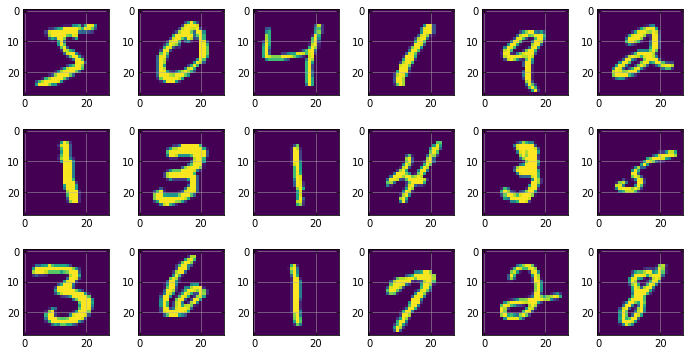

255.0
0.0
(70000, 784)
Counter({'1': 7877, '7': 7293, '3': 7141, '2': 6990, '9': 6958, '0': 6903, '6': 6876, '8': 6825, '4': 6824, '5': 6313})


In [3]:
fig, axs = plt.subplots(3,6,figsize=(12,6))
axs = axs.flatten()
N_plot = len(axs)
for i in range(N_plot):
    axs[i].imshow(mnist.data.values[i].reshape((N1,N1)))
plt.show()
print(np.max(mnist.data.values))
print(np.min(mnist.data.values))
print(np.shape(mnist.data.values))
print(Counter(mnist['target']))

The dataset consists of 70000 greyscale images. The images are encoded as 28 by 28 pixels, taking values between 0 and 255. The labels are characters representing the digits 0 to 9, and we can see that there are roughly equal numbers of samples of each in the dataset - there are more 1's and fewer 5's, but the counts are all around 7000.

Let's split up the dataset for training and testing. Two sets won't suffice, however - we'll also need a set for hyperparameter tuning, which we'll call the validation set.
We'll split the dataset up into a training set with half the data, and a validation set and test set with a quarter of the data each.
The hyperparameters we'll tune are the features that are fed into the model.
The validation set cannot give us a true estimate of the error, since it will be biased to seem
more accurate than it actually is.
When we evaluate the score on the test set for each model, at the very end, that will give us an
estimate of the error of the model.

In [4]:
X = mnist['data'].values
y = mnist['target']
test_size = 0.5
X_train, X_nottrain, y_train, y_nottrain = train_test_split(X, y, test_size=test_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_nottrain, y_nottrain, test_size=0.5, random_state=43)
print([np.shape(grp) for grp in [X_train, X_valid, X_test]])

[(35000, 784), (17500, 784), (17500, 784)]


The main model we'll test is a basic MLP with a single hidden layer of size 120. We'll use RELU as an activation function. We choose our learning rate to give us nice loss curves later.

In [5]:
## # List classifiers
## # List preproc pipes

hidden_layer_sizes = [120]
method_name, method = 'mlp', MLPClassifier
method_params = {'hidden_layer_sizes':hidden_layer_sizes, 'activation':'relu', 'random_state':16, 'tol':1e-6, 'learning_rate_init':1000e-4, 'max_iter':1000}
N_samples_cut = {LinearSVC.__name__:100, XGBClassifier.__name__:300, GradientBoostingClassifier.__name__:50}

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

"max_iter: int, default=200

Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps."

We'll use PCA to pick out a set of features which should hopefully capture the data well. This will help by reducing the noise, making the model more robust to overfitting.

In [6]:
pca_results = []
for sqrt_n_components in range(1,22,2):
    n_components = sqrt_n_components**2
    t1 = time()
    pca = PCA(n_components=n_components, random_state=42)
    pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca), (method_name, method(**method_params))])
    pca_pipe.fit(X_train, y_train)
    t2 = time()
    
    score_valid = accuracy_score(y_valid, pca_pipe.predict(X_valid))
    score_train = accuracy_score(y_train, pca_pipe.predict(X_train))
    pca_results.append([n_components, score_valid, score_train, t2-t1])
    print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)
pca_results = np.array(pca_results)
"""25	0.9596571428571429	0.9988	66.09388494491577
49	0.9676571428571429	0.9996571428571429	46.0301456451416
81	0.9693142857142857	0.9997428571428572	34.43857288360596"""

1	0.3	0.29354285714285716	11.460634708404541
9	0.8261714285714286	0.8281142857142857	8.910228729248047
25	0.8822285714285715	0.8886571428571428	11.903801918029785
49	0.8471428571428572	0.8557142857142858	28.55229926109314
81	0.9559428571428571	0.9845142857142857	42.60452723503113
121	0.9674857142857143	0.9958	47.04386878013611
169	0.9646857142857143	0.9942	44.19339299201965
225	0.962	0.9940857142857142	36.98772072792053
289	0.9576571428571429	0.9934571428571428	51.327428579330444
361	0.9560571428571428	0.9935142857142857	50.039520263671875
441	0.9526857142857142	0.9925142857142857	45.87071108818054


'25\t0.9596571428571429\t0.9988\t66.09388494491577\n49\t0.9676571428571429\t0.9996571428571429\t46.0301456451416\n81\t0.9693142857142857\t0.9997428571428572\t34.43857288360596'

Let's examine the confusion matrix and loss curve for the model with n_features=441.

[0.98383372 0.97894196 0.90028011 0.94240542 0.96560197 0.93859649
 0.97760358 0.94548458 0.94993895 0.9422543 ]


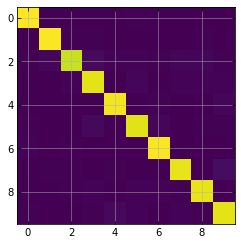

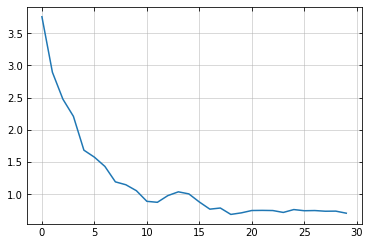

In [16]:
con = confusion_matrix(y_valid, pca_pipe.predict(X_valid), normalize='true')
print(np.diag(con))
plt.imshow(con)
plt.show()
#for a in con:
#    for b in a:
#        print(round(b,3), end='\t')
#    print('')
plt.plot(pca_pipe[method_name].loss_curve_)
plt.show()

It seems pretty even, doesn't look like the model is concentrating too much on any particular digit.
The loss curve is smooth, giving us some hope that we have chosen our learning rate correctly.

What if we train the same MLP using the full dataset?

In [17]:
## # Full
n_components = X_valid.shape[1]
#print(n_components)
t1 = time()
full_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
full_pipe.fit(X_train, y_train)
t2 = time()
score_valid = accuracy_score(y_valid, full_pipe.predict(X_valid))
score_train = accuracy_score(y_train, full_pipe.predict(X_train))
full_result = [n_components, score_valid, score_train, t2-t1]
print('Features\tValidation score\tTrain score\tTime taken [s]')
print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)

Features	Validation score	Train score	Time taken
784	0.9604571428571429	0.9937714285714285	51.992602586746216


Let's compare XGBClassifier, LinearSVC and GradientBoostingClassifier.
They are quite slow in comparison with the MLP, so we will reduce the data that we train them on.

In [9]:
## # Move to end?
## # Is there an even class distr after the cut?
#'''
methods = [XGBClassifier, LinearSVC, GradientBoostingClassifier]#, SVC]
mthd_params = dict()
mthd_params[LinearSVC.__name__] = {'max_iter':4000}
mthd_params[XGBClassifier.__name__] = {'use_label_encoder':False, "objective":"multi:softmax","num_class":10, "eval_metric":"mlogloss"}
mthd_params[GradientBoostingClassifier.__name__] = {}

## # Bad naming - need to clean up method vs mthd.
mthd_results = []
#print(help(XGBClassifier.score))
for mthd in methods:
    #print(mthd.__name__, end='\t', flush=True)
    n_components = X_valid.shape[1]
    t1 = time()
    #print(np.shape(X_train[:100,:100]))
    mthd_pipe = Pipeline([('scaler', StandardScaler()), (mthd.__name__, mthd(**mthd_params[mthd.__name__]))])
    cut = N_samples_cut[mthd.__name__]
    print(f'Using {cut} samples to train.')
    #print(X_train[:cut][:10].sum())
    #print(y_train[:cut][:10].values)
    if mthd.__name__=='XGBClassifier':
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(y_train[:cut].astype("category"))
        mthd_pipe.fit(X_train[:cut], label_encoder.transform(y_train[:cut].astype("category")))
    else:
        mthd_pipe.fit(X_train[:cut], y_train[:cut])
    t2 = time()
    #print(mthd_pipe.predict(X_valid[:10]))
    #print(y_valid[:10].values)
    score_valid, score_train = 0., 0.
    if mthd.__name__=='XGBClassifier':
        score_valid = accuracy_score(label_encoder.transform(y_valid[:cut]), mthd_pipe.predict(X_valid[:cut]))
        score_train = accuracy_score(label_encoder.transform(y_train[:cut]), mthd_pipe.predict(X_train[:cut]))
    else:
        score_valid = accuracy_score(y_valid[:cut], mthd_pipe.predict(X_valid[:cut]))
        score_train = accuracy_score(y_train[:cut], mthd_pipe.predict(X_train[:cut]))
    mthd_results.append([n_components, score_valid, score_train, t2-t1])
    print(mthd.__name__, cut, score_valid, score_train, round((t2-t1),2), sep='\t', flush=True)#'''
"""XGBClassifier	10000	0.9529	1.0	80.43"""
"""XGBClassifier	30000	0.9730857142857143	1.0	258.93
LinearSVC	10000	0.8603	0.9772	49.94
GradientBoostingClassifier	5000	0.919	0.9992	212.92"""
pass

XGBClassifier	300	0.7466666666666667	1.0	5.81
LinearSVC	100	0.51	1.0	0.23
GradientBoostingClassifier	50	0.44	1.0	4.37


What if we train the same MLP using the full dataset, with the target labels randomly permuted?
There should be no signal here, the entire training set should be noise.
If our model can achieve a good training score, that would mean our model is capable of extremely overfitting the data.
By comparing with this example, we can have confidence our model really is capable of learning something.

In [18]:
## # Random (no signal, all noise)
n_components = X_valid.shape[1]
#print(n_components)
t1 = time()
rand_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
permed_train = permutation(y_train)
rand_pipe.fit(X_train, permed_train)
t2 = time()
score_valid = accuracy_score(y_valid, rand_pipe.predict(X_valid))
score_train = accuracy_score(permed_train, rand_pipe.predict(X_train))
rand_result = [n_components, score_valid, score_train, t2-t1]
print('Features\tValidation score\tTrain score\tTime taken [s]')
print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)

Features	Validation score	Train score	Time taken [s]
784	0.094	0.10177142857142857	23.558812141418457


The training score of 0.62 is due to the ability of the model to overfit the data. As expected, the validation score is around 0.1,
reflecting the even distribution of classes in the training and validation sets - the model is essentially guessing.

Let's try using the coefficients of a 2D Legendre decomposition as features for our model.

In [11]:
N_pixel=28
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])

Q = np.zeros((N_pixel, N_pixel))
for n in range(N_pixel):
    for i in range(N_pixel):
        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]

leg_results = []
X_train_sq = X_train.reshape((-1,28,28))
X_valid_sq = X_valid.reshape((-1,28,28))
print('Features\tValidation score\tTrain score\tTime taken [s]')
for Nmax in range(1, 22, 2):
    t1 = time()
    ## # Converting pixel features to Legendre features,
    ## # reducing dimensionality and smoothing.
    ## # Training set:
    leg_features = []
    for to_fit in X_train_sq:
        coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
        coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
        leg_features.append(coeffs.flatten())
    leg_features = np.array(leg_features)

    ## # Fitting the model
    leg_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
    leg_pipe.fit(leg_features, y_train)
    t2 = time()
    
    ## # Validation set:
    leg_valid = []
    for to_fit in X_valid_sq:
        coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
        coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
        leg_valid.append(coeffs.flatten())
    leg_valid = np.array(leg_valid)
    score_valid = accuracy_score(y_valid, leg_pipe.predict(leg_valid))
    score_train = accuracy_score(y_train, leg_pipe.predict(leg_features))
    leg_results.append([Nmax**2, score_valid, score_train, t2-t1])
    print(Nmax**2, score_valid, score_train, t2-t1, sep='\t', flush=True)

1	0.23114285714285715	0.22831428571428572	7.131827116012573
9	0.7524	0.7517142857142857	14.858339071273804
25	0.8901142857142857	0.8937142857142857	9.288799524307251
49	0.9096571428571428	0.9136285714285715	10.4783034324646
81	0.9038285714285714	0.9076285714285715	13.640034198760986
121	0.8962857142857142	0.9082857142857143	43.400872468948364
169	0.9700571428571428	0.992	44.3202919960022
225	0.9708	0.9945142857142857	40.55353808403015
289	0.9704571428571429	0.9952	40.633360862731934
361	0.9693714285714286	0.9935714285714285	40.284963846206665
441	0.9652571428571428	0.9918	36.275179862976074


Now we'll plot the scores and times as we increase the numbers of features.
We'll also plot the loss curves of the models with the maximum number of features.

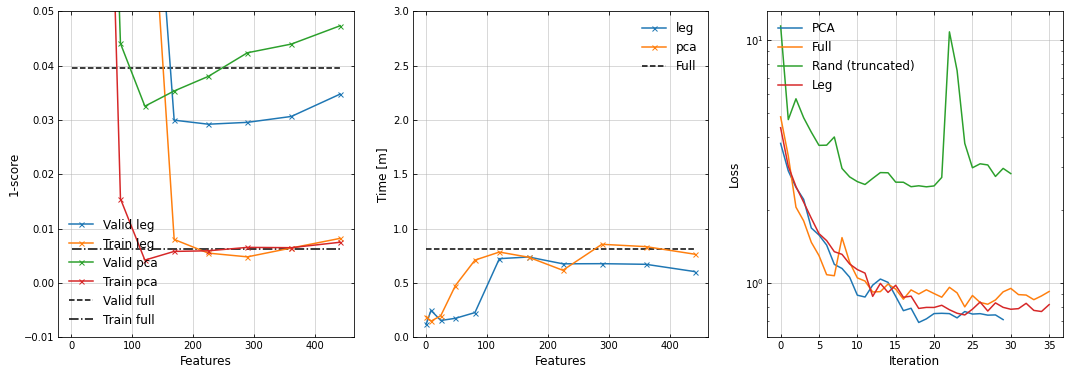

Final value of rand loss: 31 iterations gives loss=2.82.


In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot([r[0] for r in leg_results], [1-r[1] for r in leg_results], '-x', label='Valid leg')
axs[0].plot([r[0] for r in leg_results], [1-r[2] for r in leg_results], '-x', label='Train leg')
axs[1].plot([r[0] for r in leg_results], [r[3]/60 for r in leg_results], '-x', label='leg')
axs[0].plot([r[0] for r in pca_results], [1-r[1] for r in pca_results], '-x', label='Valid pca')
axs[0].plot([r[0] for r in pca_results], [1-r[2] for r in pca_results], '-x', label='Train pca')
axs[1].plot([r[0] for r in pca_results], [r[3]/60 for r in pca_results], '-x', label='pca')
xmin, xmax = min(pca_results[:,0]), max(pca_results[:,0])
axs[0].hlines(1-full_result[1], xmin, xmax, linestyles='--', label='Valid full')
axs[0].hlines(1-full_result[2], xmin, xmax, linestyles='-.', label='Train full')
axs[1].hlines(full_result[3]/60, xmin, xmax, linestyles='--', label='Full')
axs[2].plot(pca_pipe[method_name].loss_curve_, '-', label='PCA')
axs[2].plot(full_pipe[method_name].loss_curve_, '-', label='Full')
axs[2].plot(rand_pipe[method_name].loss_curve_[:len(leg_pipe[method_name].loss_curve_)], '-', label='Rand (truncated)')
axs[2].plot(leg_pipe[method_name].loss_curve_, '-', label='Leg')
axs[2].set_yscale('log')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_xlabel('Features')
axs[0].set_ylabel('1-score')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Time [m]')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Iteration')
axs[0].set_ylim(-0.01, 0.05)
axs[1].set_ylim(0, 3.)
plt.show()
print(f"Final value of rand loss: {len(rand_pipe[method_name].loss_curve_)} iterations gives loss={round(rand_pipe[method_name].loss_curve_[-1],2)}.")

The plots show there is no significant difference in time. The validation score curves show us that
the Legendre features are more robust to overfitting.
Spikes in the loss curves are due to having a learning rate that is too large.

Using all the features leads to overfitting. PCA helps, but since the features are picked based on variance they might not actually hold the cluster information. Legendre coefficients as features cut out noise, but can also make use of more features before giving in to overfitting, hence achieve a better validation score (though the difference is only marginal, 97.55% compared to 97.07%).

Interpret loss curve. Spikes are probably from weird batches, making the learning rate smaller shrinks them. We only go up to 21X21 features so PCA and Legendre curves don't match Full.

What about training our other models (XGBClassifier, LinearSVC, GradientBoostingClassifier) on the Legendre features,
with Nmax=13?

In [13]:
X_train_sq = X_train.reshape((-1,28,28))
X_valid_sq = X_valid.reshape((-1,28,28))
Nmax = 13
## # Converting pixel features to Legendre features,
## # reducing dimensionality and smoothing.
## # Training set:
leg_train = []
for to_fit in X_train_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    leg_train.append(coeffs.flatten())
leg_train = np.array(leg_train)

## # Validation set:
leg_valid = []
for to_fit in X_valid_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    leg_valid.append(coeffs.flatten())
leg_valid = np.array(leg_valid)
    
#######

methods = [XGBClassifier, LinearSVC, GradientBoostingClassifier]#, SVC]
mthd_params = dict()
mthd_params[LinearSVC.__name__] = {'max_iter':2000}
mthd_params[XGBClassifier.__name__] = {'use_label_encoder':False, "objective":"multi:softmax","num_class":10, "eval_metric":"mlogloss"}
mthd_params[GradientBoostingClassifier.__name__] = {}
## # Bad naming - need to clean up method vs mthd.
mthd_results = []
#print(XGBClassifier.score.__name__)
for mthd in methods:
    n_components = leg_valid.shape[1]
    mthd_pipe = Pipeline([('scaler', StandardScaler()), (mthd.__name__, mthd(**mthd_params[mthd.__name__]))])
    cut = N_samples_cut[mthd.__name__]
    t1 = time()
    if mthd.__name__=='XGBClassifier':
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(y_train[:cut].astype("category"))
        mthd_pipe.fit(leg_train[:cut], label_encoder.transform(y_train[:cut].astype("category")))
    else:
        mthd_pipe.fit(leg_train[:cut], y_train[:cut])
    t2 = time()
    score_valid, score_train = 0., 0.
    if mthd.__name__=='XGBClassifier':
        score_valid = accuracy_score(label_encoder.transform(y_valid[:cut]), mthd_pipe.predict(leg_valid[:cut]))
        score_train = accuracy_score(label_encoder.transform(y_train[:cut]), mthd_pipe.predict(leg_train[:cut]))
    else:
        score_valid = accuracy_score(y_valid[:cut], mthd_pipe.predict(leg_valid[:cut]))
        score_train = accuracy_score(y_train[:cut], mthd_pipe.predict(leg_train[:cut]))
    mthd_results.append([n_components, score_valid, score_train, t2-t1])
    print(mthd.__name__, cut, score_valid, score_train, round((t2-t1),2), sep='\t', flush=True)
"""With no preprocessing:
XGBClassifier	30000	0.9730857142857143	1.0	258.93
LinearSVC	10000	0.8603	0.9772	49.94
GradientBoostingClassifier	5000	0.919	0.9992	212.92"""
pass

XGBClassifier	300	0.7766666666666666	1.0	1.45
LinearSVC	100	0.63	1.0	0.23
GradientBoostingClassifier	50	0.24	1.0	3.3


We could also give more general orthogonal polynomials a try, for example polynomials orthogonal to some weight function on the space. This possibly already exists in the literature. We won't explore it any further here, though.

Grand finale
-----
Comparison on the test set, after hyperparameter tuning on the validation set. Legendre Nmax=16(?) (call this Leg_opt) seems most robust to overfitting, so compare the four methods using Leg_opt and the full dataset. Can I train on Valid? Test gives estimate of prediction error.

"The error rate estimate of the final model on validation data will be biased (smaller than the true error rate) since the validation set is used to select the final model After assessing the final model on the test set, YOU MUST NOT tune the model any further!" (also score on Train is biased, obv...)

* XGBClassifier, with Leg_opt and full.
* LinearSVC, with Leg_opt and full.
* GradientBoostingClassifier, with Leg_opt and full.
* MLP, with Leg_opt and full.

Bonus
---

How well do the Legendre decompositions capture the image?

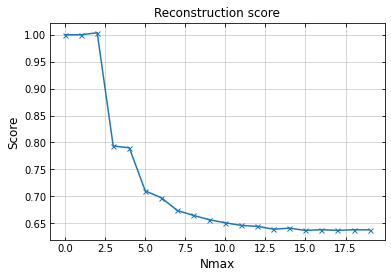

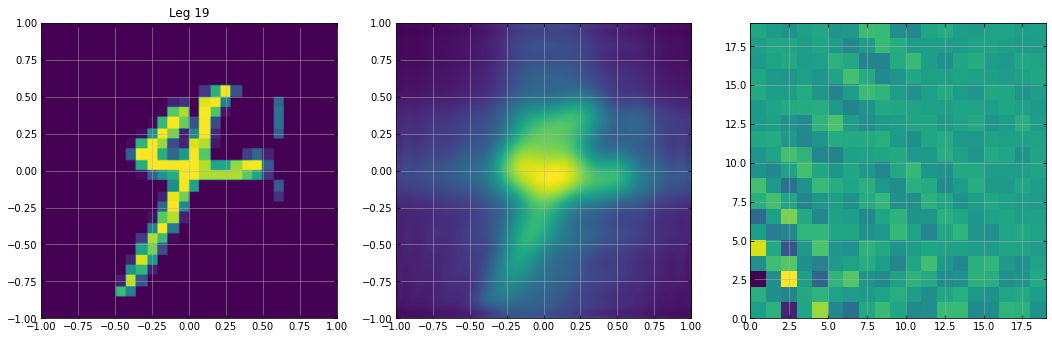

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	


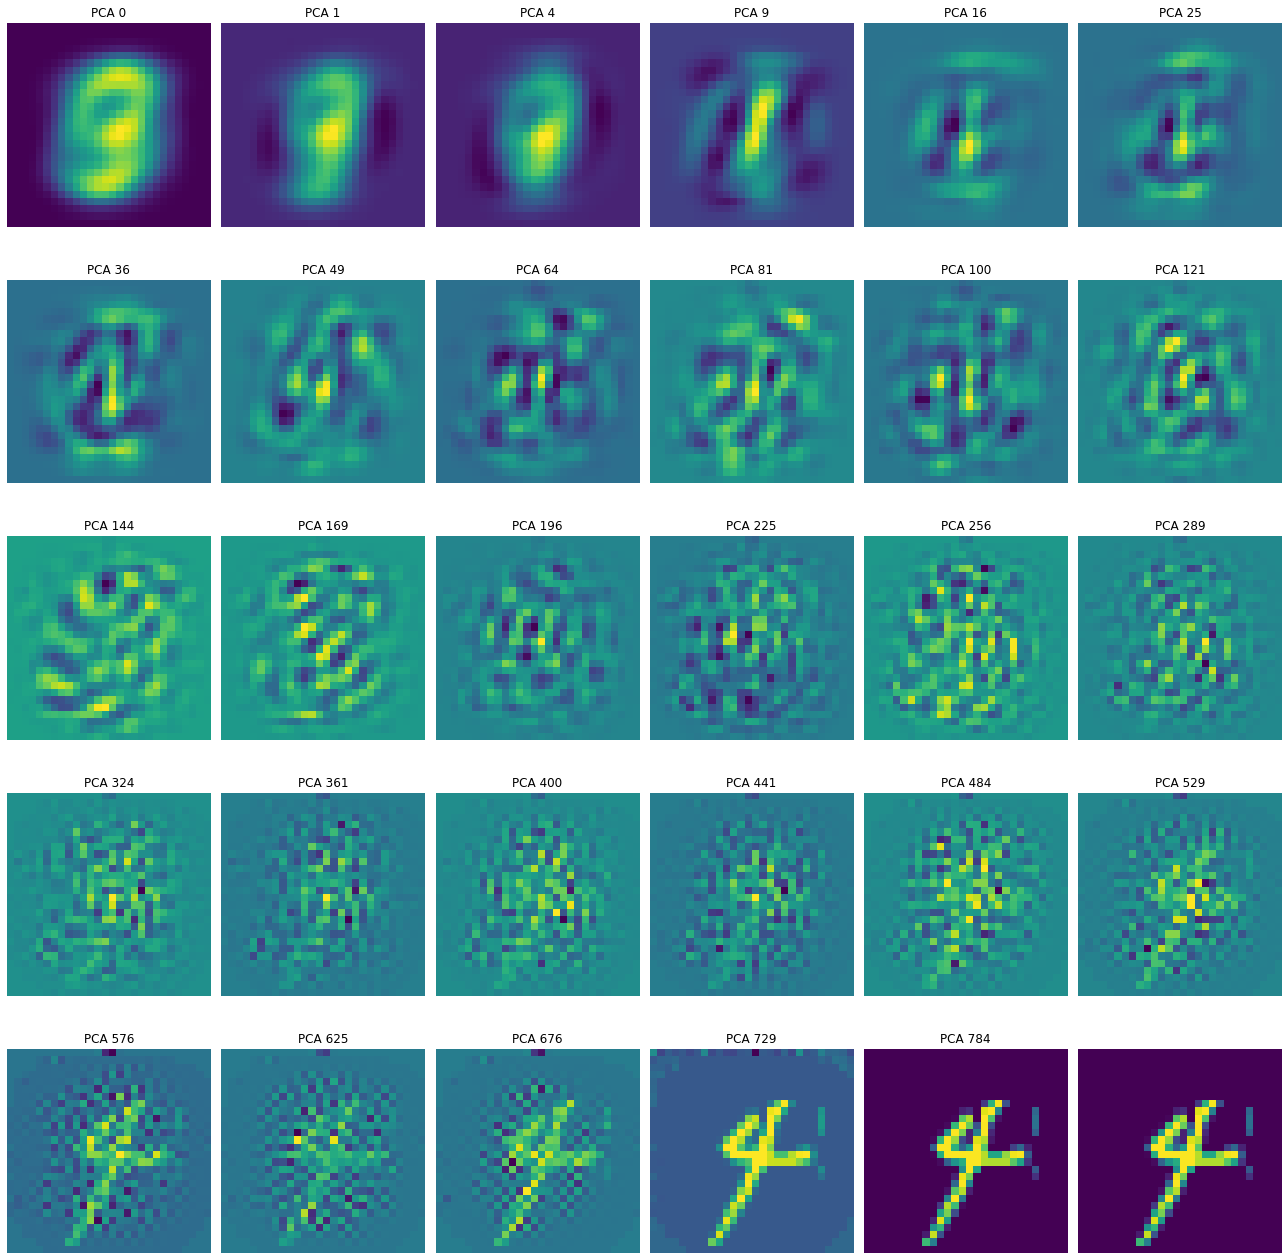

In [14]:
## # 2d
N_pixel = 28
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])
mnist_ind = 53
## # Careful to copy, not view!
to_fit = np.copy(mnist['data'].values[mnist_ind].reshape((28,28)))
to_fit -= to_fit.mean()
to_fit = to_fit/to_fit.std()
#to_fit = np.clip(to_fit, 0, 255)
#print(breaks)
def func(x, y):
    x = np.clip(np.ceil((1+x)*N_pixel/2), 0, 27)
    y = np.clip(np.ceil((1+y)*N_pixel/2), 0, 27)
    temp = to_fit[y.astype(np.int64), x.astype(np.int64)]
    return temp

N_plot = 150
xs = np.linspace(-1, 1, N_plot, endpoint=True)
ys = np.linspace(-1, 1, N_plot, endpoint=True)
f_xs, f_ys = np.meshgrid(xs, ys)[0].flatten(), np.meshgrid(xs, ys)[1].flatten()
fns = func(f_xs, f_ys)
#fig, ax = plt.subplots(1, 1, figsize=(12,6))
#ax.imshow(fns.reshape((N_plot, N_plot)), label='real', extent=[-1, 1, -1, 1])
#plt.show()

N = 101
## # We should already have this from above?
Q = np.zeros((N_pixel, N_pixel))
for n in range(N_pixel):
    for i in range(N_pixel):
        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]
recon_res = []
for Nmax in range(20):#range(1,32,10):
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    #print(np.shape(coeffs))       
    N_plot = 150
    xs = np.linspace(-1, 1, N_plot, endpoint=True)
    ys = np.linspace(-1, 1, N_plot, endpoint=True)
    f_xs, f_ys = np.meshgrid(xs, ys)[0].flatten(), np.meshgrid(xs, ys)[1].flatten()
    fns = func(f_xs, f_ys)
    recomp = np.dot(coeffs, [eval_legendre(n, xs) for n in range(Nmax)])
    #print(1, np.shape(recomp))
    recomp = np.dot(recomp.T, [eval_legendre(n, xs) for n in range(Nmax)]).flatten()
    #print(2, np.shape(recomp))
    recon_res.append([Nmax, np.sum((recomp-fns)**2)/np.sum(fns**2)])
recon_res = np.array(recon_res)
#print('\n',np.sum(coeffs**2))
plt.title('Reconstruction score')
plt.plot(recon_res[:,0], recon_res[:,1], '-x')
plt.ylabel('Score')
plt.xlabel('Nmax')
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].set_title(f'Leg {Nmax}')
axs[0].imshow(fns.reshape((N_plot, N_plot)), label='real', extent=[-1, 1, -1, 1])
axs[1].imshow(recomp.reshape((N_plot, N_plot)), label='recomp', extent=[-1, 1, -1, 1])
axs[2].imshow(coeffs[::-1,:], extent=[0, Nmax, 0, Nmax])
plt.show()
########################
fig, axs = plt.subplots(5, 6, figsize=(18,18))
axs = axs.flatten()
for sqrt_n_components in range(29):
    ## # Don't need to retrain the pipe every time, just use the first n.
    pca = PCA(n_components=sqrt_n_components**2, random_state=42)
    pca_only_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
    pca_only_pipe.fit(X_train)
    pca_fit = pca_only_pipe.transform(to_fit.reshape((1,-1)))
    pca_inv_fit = pca_only_pipe.inverse_transform(pca_fit).reshape((28,28))
    #fig, axs = plt.subplots(1, 3, figsize=(18,6))
    axs[sqrt_n_components].set_title(f'PCA {sqrt_n_components**2}')
    #axs[0].imshow(to_fit, label='real', extent=[-1, 1, -1, 1])
    axs[sqrt_n_components].imshow(pca_inv_fit, label='recomp', extent=[-1, 1, -1, 1])
    #axs[2].imshow(pca_fit.reshape((28,28))[::-1,:], extent=[0, Nmax, 0, Nmax])
    print(sqrt_n_components, end='\t', flush=True)
    axs[sqrt_n_components].axis('off')
print('')
axs[-1].axis('off')
axs[-1].imshow(to_fit, label='recomp', extent=[-1, 1, -1, 1])
plt.tight_layout()
plt.show()

What does the distribution of coefficients look like?

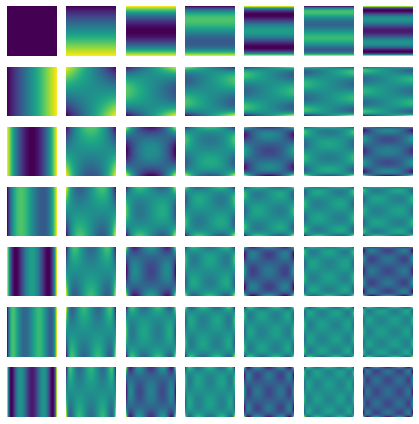

In [15]:
#print(coeffs[:3,:3])
#print(coeffs[-3:,-3:])
N_plot = 101
ps = np.linspace(-1, 1, N_plot, endpoint=True)
xs, ys = np.meshgrid(ps, ps)[0].flatten(), np.meshgrid(ps, ps)[1].flatten()
Nmax_plot = 7
fig, axs = plt.subplots(Nmax_plot, Nmax_plot, figsize=(6,6))
for n1 in range(Nmax_plot):
    temp = eval_legendre(n1, xs)*np.sqrt(n1+0.5)
    for n2 in range(Nmax_plot):
        temp2 = temp*eval_legendre(n2, ys)*np.sqrt(n2+0.5)
        #axs[n1][n2].set_title(f'{n1}, {n2}')
        axs[n1][n2].imshow(temp2.reshape((N_plot,N_plot)))
        axs[n1][n2].axis('off')
plt.tight_layout()
plt.show()